# ValidateTempSalinity

Ben Roberts, 2022

Perform a validtion of FVCOM water temperature and salinity output against observations compiled in a [database](https://github.com/bedaro/puget_sound_obsdata). This is loosely based on a Python notebook I wrote in summer 2020 for validation of King County's Puget Sound Aquatic Biogeochemical Cycling (PSABC) model, and most of the plots are designed to mimic the ones Ecology uses in their Bounding Scenarios report.

## Parameters

 * `model_output_pattern`: A glob pattern of all the NetCDF files from the hydrodynamic model run.
 * `run_name`: The name of this particular run, used to name the output files.
 * `start_date`: A plain text start date for when the model run began, which will be read with pd.Timestamp.
 * `end_date`: A plain text end date for when to stop validating the model output. This can just be set to None to use the end of the model output, but some ways to run the model let it continue running after boundary condition files have ended, and after that point this will corrupt the fit statistics.
 * `exclude_station_ids`: A sequence of station IDs to exclude from the validation, even though they fall within the model domain and had observations during the run period.
 * `stats_max_per_station`: To deal with automated buoys that have observations at a much higher frequency than human-collected data, any station with a total number of observations that exceeds this threshold will be subsampled randomly.
 * `fancy_station_map`: Makes a labeled map of all the observation stations used in the validation. Calculating label locations is quite slow due to one particularly inefficient python module. To speed up the notebook and skip the labeling, set this to False.

In [1]:
model_output_pattern = '/net/babaracus/home/benr/wqmodels/ssm/newinputs/1_control/hyd_year1/OUTPUT/netcdf/ssm_*.nc'
run_name = 'newinput_ctrl_year1'
start_date = '2014-01-01'
end_date = '2014-12-31'
#end_date = None

# Don't validate with data from the Pacific coast (Willapa Bay, Grays Harbor)
exclude_station_ids = ('WPA001','WPA003','WPA004','WPA006','WPA007',
                       'WPA008','WPA102','WPA113','GYS004','GYS008',
                       'GYS009','GYS015','GYS016')
stats_max_per_station = 240

fancy_station_map = True

import os
import os.path as path
from multiprocessing import Pool
from time import perf_counter
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import MFDataset
import matplotlib.pyplot as plt
import contextily as cx
import db
from fvcom import FvcomGrid
import validation_util as vu

In [2]:
model_output = MFDataset(model_output_pattern)
model_output

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: FVCOM Velocity Blockage Test(Updated Block with Kelp June 2013)                 
    institution: School for Marine Science and Technology
    source: FVCOM_2.7
    history: model started at: 27/01/2023   12:03
    references: http://fvcom.smast.umassd.edu
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'obc', 'obc2', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'lon', 'lat', 'siglay', 'siglay_shift', 'siglev', 'h', 'nv', 'a1u', 'a2u', 'aw0', 'awx', 'awy', 'time', 'iint', 'u', 'v', 'ww', 'wts', 'uard_obcn', 'xflux_obc', 'dtfa', 'kh', 'zeta', 'salinity', 'temp')
    groups = ()

In [3]:
out_file = lambda name: path.join("notebook_outs", run_name, name)
os.makedirs(os.path.dirname(out_file('foo')), exist_ok=True)

In [4]:
engine = db.connect()
v = vu.ModelValidator(start_date, model_output, engine=engine, end_date=end_date)
display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2014-01-01 08:00:00+00:00 to 2014-12-31 08:00:00+00:00'

In [5]:
temp_obs = v.get_obsdata('temp', exclude_stations=exclude_station_ids)
print(f'{len(temp_obs)} total temperature measurements')
print(f'{len(temp_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
temp_obs.head()

646180 total temperature measurements
8480 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
18581712,2014-01-01 08:00:00+00:00,1.204,8.92,PointWilliams,None,temp
18946419,2014-01-01 08:00:00+00:00,5.036,8.86,Dockton,None,temp
18581713,2014-01-01 08:15:00+00:00,1.214,8.92,PointWilliams,None,temp
18946420,2014-01-01 08:15:00+00:00,5.285,8.91,Dockton,None,temp
18581714,2014-01-01 08:30:00+00:00,1.218,8.92,PointWilliams,None,temp


In [6]:
salt_obs = v.get_obsdata('salt', exclude_stations=exclude_station_ids)
print(f'{len(salt_obs)} total temperature measurements')
print(f'{len(salt_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
salt_obs.head()

600395 total temperature measurements
8480 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
51216393,2014-01-01 20:23:57.750000+00:00,2.704065,30.075798,HC_DB,860e057d-8bde-4d83-b30b-c504090036b0,salt
51216400,2014-01-01 20:24:12.500035+00:00,3.453308,30.083554,HC_DB,860e057d-8bde-4d83-b30b-c504090036b0,salt
51216405,2014-01-01 20:24:18.999993+00:00,4.451769,30.085277,HC_DB,860e057d-8bde-4d83-b30b-c504090036b0,salt
51216410,2014-01-01 20:24:25.500038+00:00,5.464462,30.086408,HC_DB,860e057d-8bde-4d83-b30b-c504090036b0,salt
51216416,2014-01-01 20:24:31.749955+00:00,6.441250,30.085817,HC_DB,860e057d-8bde-4d83-b30b-c504090036b0,salt


In [7]:
stations = gpd.read_postgis("SELECT * FROM obsdata.stations", con=engine)
stations = stations.loc[stations['name'].isin(temp_obs['location_id'])]
print(f'{len(stations)} total stations in validation set')
stations.head()

92 total stations in validation set


,name,description,geom
0,RSR837,Strait of Georgia: Rosario Strait - Peapod Rock,POINT (517470.419 5384851.335)
10,HCB007,Hood Canal - Lynch Cove,POINT (505409.261 5249433.731)
11,HCB010,"Hood Canal - Send Creek, Bangor Post 9/11/2001...",POINT (513512.242 5279306.044)
15,SIN001,Sinclair Inlet - Naval Shipyards,POINT (526958.030 5266349.377)
16,SJF000,Strait of Juan de Fuca - South of Cattle Point...,POINT (498150.179 5362613.353)


In [8]:
grid = FvcomGrid.from_output(model_output)
model_points = grid.nodes_gdf()
del model_points['depth']
print(len(model_points))
model_points.head()

16012


,geometry
1,POINT (413209.812 4916091.500)
2,POINT (400581.406 4916573.500)
3,POINT (390430.062 4916456.500)
4,POINT (380630.000 4918330.000)
5,POINT (375680.000 4925140.000)


Load the full grid shapefile

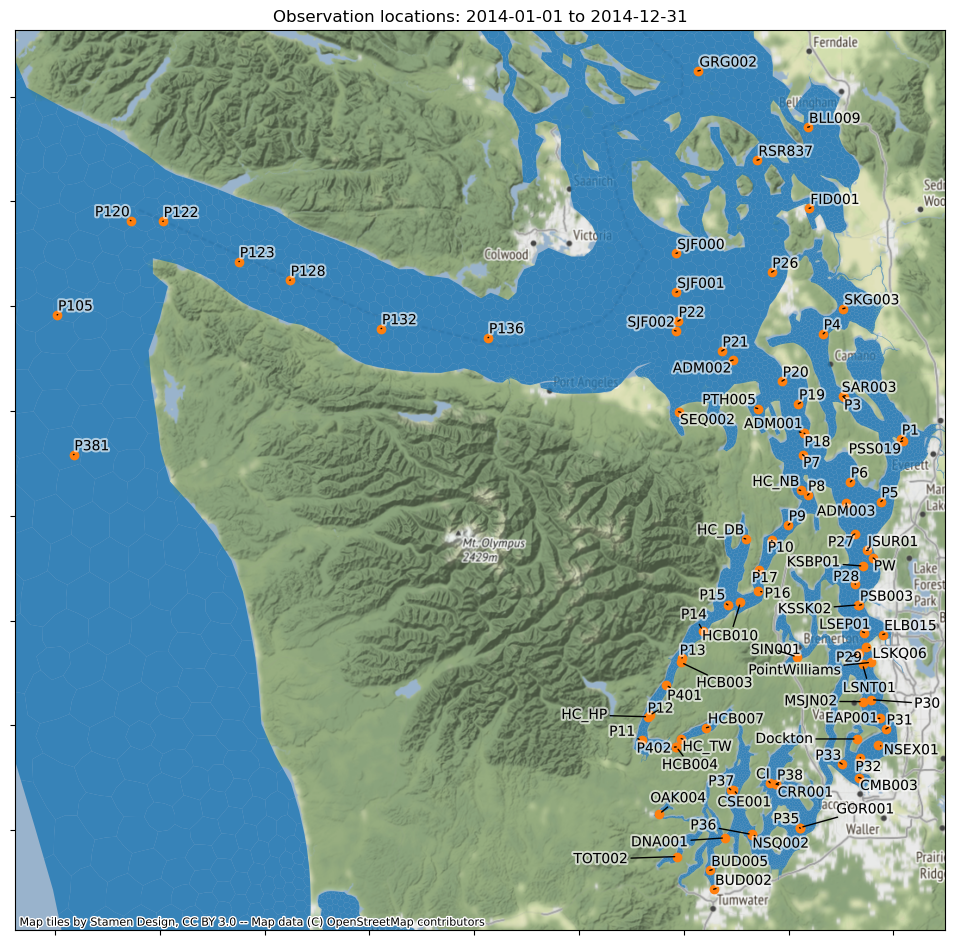

In [9]:
full_grid = grid.tces_gdf()
fig, ax = plt.subplots(figsize=(12,12))
p = stations.plot(ax=ax, color='tab:orange', zorder=2)
# Save the axes boundaries so we can restore them after plotting the full model
# boundary
xmin, xmax, ymin, ymax = p.axis()
if fancy_station_map:
    from adjustText import adjust_text
    import matplotlib.patheffects as pe
    texts = stations.apply(
        lambda x: ax.annotate(x['name'], xy=x['geom'].coords[0], ha='center', va='center',
                              path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.6)]
                             ), axis=1)
    adjust_text(texts, arrowprops=dict(arrowstyle='-'))
full_grid.plot(ax=ax, alpha=0.8, zorder=1)
ax.set(title=f'Observation locations: {v.start_date.date()} to {v.end_date.date()}',
       ybound=(ymin, ymax), xbound=(xmin, xmax), xticklabels=(), yticklabels=())
cx.add_basemap(ax, crs=full_grid.crs)
if fancy_station_map:
    fig.savefig(out_file("stations_map.png"))

Now perform the spatial joins. First we join against the full model domain to exclude any stations outside of it.

In [10]:
stations_in_grid = gpd.tools.sjoin(stations, full_grid)[['name','description','geom']]
station_nodes = gpd.tools.sjoin_nearest(stations_in_grid, model_points).set_index('name').rename(columns={'index_right': 'node'})
print(f'{len(station_nodes)} stations inside grid')
station_nodes.head()

90 stations inside grid


,description,geom,node
name,,,
RSR837,Strait of Georgia: Rosario Strait - Peapod Rock,POINT (517470.419 5384851.335),5102
HCB007,Hood Canal - Lynch Cove,POINT (505409.261 5249433.731),14049
HCB010,"Hood Canal - Send Creek, Bangor Post 9/11/2001...",POINT (513512.242 5279306.044),9887
SIN001,Sinclair Inlet - Naval Shipyards,POINT (526958.030 5266349.377),11793
SJF000,Strait of Juan de Fuca - South of Cattle Point...,POINT (498150.179 5362613.353),3636


In [11]:
temp_obs = temp_obs.merge(station_nodes, left_on='location_id', right_index=True)
salt_obs = salt_obs.merge(station_nodes, left_on='location_id', right_index=True)
temp_obs.head()

,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
18581712,2014-01-01 08:00:00+00:00,1.204,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
18581713,2014-01-01 08:15:00+00:00,1.214,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
18581714,2014-01-01 08:30:00+00:00,1.218,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
18581715,2014-01-01 08:45:00+00:00,1.219,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
18581716,2014-01-01 09:00:00+00:00,1.219,8.91,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977


In [12]:
start = perf_counter()
# Group by cast
dfs = [v.process_cast(c, group) for c,group in temp_obs.groupby('cast_id')]
# This won't work right now because MFDataset can't be parallelized (not
# picklable). Migrating over to xarray is the only way forward I know of
#with Pool() as pool:
#    dfs = pool.starmap(v.process_cast, temp_obs.groupby('cast_id'))
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(temp_obs.loc[temp_obs['cast_id'].isna()]))

temp_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
print("processing took {0:.3f} secs".format(perf_counter()-start))
temp_validation_df.to_csv(out_file("temp_validation.csv"), index=False)
temp_validation_df

processing took 56.405 secs


,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,4.467579,2,9.685647,9.406914
1,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,9.364276,3,8.701786,9.284168
2,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,15.399239,4,8.387035,8.591854
3,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,22.382479,5,8.235645,8.701222
4,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,30.197466,6,8.372512,8.836496
...,...,...,...,...,...,...,...,...,...
81415,NSEX01,12735,NaN,2014-06-03 19:28:31+00:00,3682,1.000000,1,12.227000,12.233409
81416,NSEX01,12735,NaN,2014-07-22 21:00:02+00:00,4860,170.500000,10,10.725800,10.611721
81417,NSEX01,12735,NaN,2014-07-22 21:00:05+00:00,4860,171.000000,10,10.725700,10.611721
81418,NSEX01,12735,NaN,2014-07-22 21:00:07+00:00,4860,171.500000,10,10.725600,10.611721


In [13]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in salt_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(salt_obs.loc[salt_obs['cast_id'].isna()]))

salt_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
salt_validation_df.to_csv(out_file("salt_validation.csv"), index=False)
salt_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,4.467579,2,27.099351,28.291405
1,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,9.364276,3,28.960755,28.557228
2,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,15.399239,4,29.192679,29.639761
3,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,22.382479,5,29.366569,29.695738
4,HC_HP,13094,00093b55-49d2-4cf3-a5e0-5e75aef89ef4,2014-04-20 12:20:06.999993+00:00,2619,30.197466,6,29.502006,29.775274
...,...,...,...,...,...,...,...,...,...
64231,NSEX01,12735,NaN,2014-06-03 19:28:31+00:00,3682,1.000000,1,26.512100,24.272326
64232,NSEX01,12735,NaN,2014-07-22 21:00:02+00:00,4860,170.500000,10,30.058500,29.882511
64233,NSEX01,12735,NaN,2014-07-22 21:00:05+00:00,4860,171.000000,10,30.058600,29.882511
64234,NSEX01,12735,NaN,2014-07-22 21:00:07+00:00,4860,171.500000,10,30.059500,29.882511


,Metric,R,RMSE,Bias,n
0,Temperature,0.899606,1.023978,-0.245141,6568
1,Salinity,0.786505,1.085135,-0.115484,6317


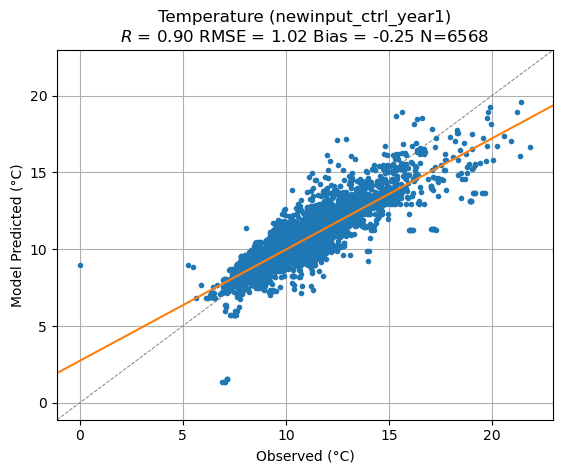

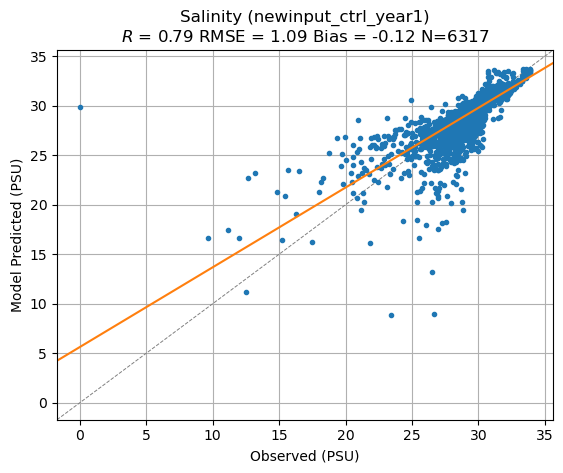

In [14]:
cum_stats = []
for pfx, label, data, unit in zip(('temp','salt'),
        ("Temperature","Salinity"),
        (temp_validation_df,salt_validation_df),
        ("\u00b0C","PSU")):
    if data.empty:
        continue
    # Downsample any stations with a high number of total observations
    # (ie automated buoys), otherwise a small number of stations will skew
    # the results heavily toward just showing how well the model represents
    # a handful of locations
    sampled = []
    for s,group in data.groupby('location'):
        if len(group) > stats_max_per_station:
            samp = group.sample(n=stats_max_per_station)
        else:
            samp = group
        sampled.append(samp)
    sampled_df = pd.concat(sampled)
    fit, rsq, rmse, bias, n = vu.run_stats(sampled_df["observed"], sampled_df["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, sampled_df['observed'], sampled_df['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","Bias","n"]))

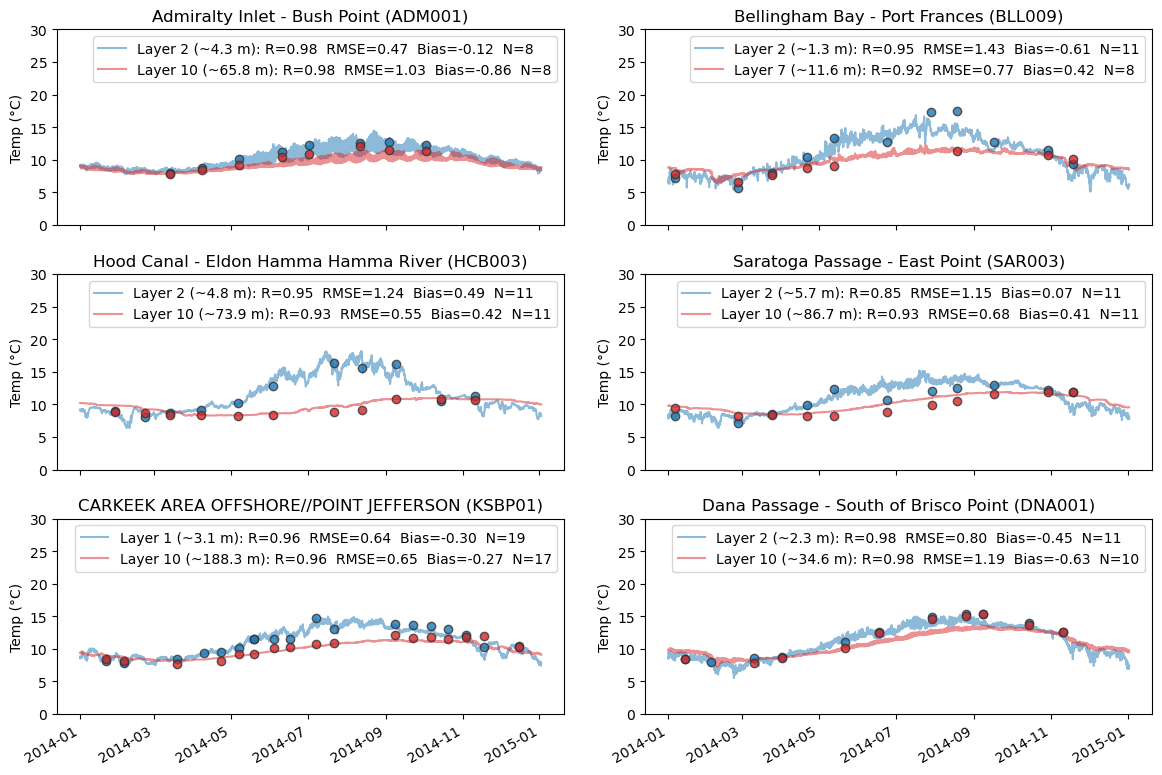

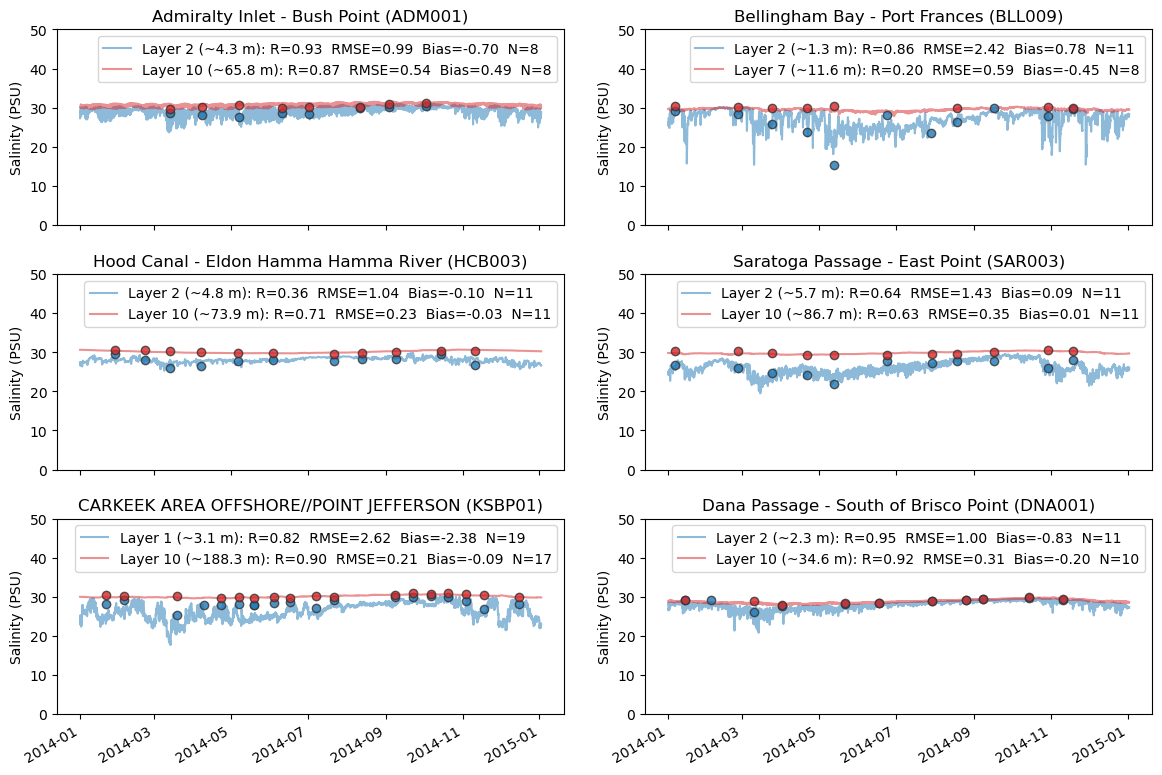

In [15]:
# Build time series plots of temperature and salinity that
# mimic figs 19 and 20 in the Bounding Scenarios report

plot_stations = ["ADM001","BLL009","HCB003","SAR003","KSBP01","DNA001"]
colors = ('tab:blue','tab:red')
datasets = {
    "temp": {
        "data": temp_validation_df,
        "obsdata": temp_obs,
        "ylabel": "Temp (\u00b0C)",
        "ybound": (0, 30),
        "xbound": (5, 27)
    },
    "salinity": {
        "data": salt_validation_df,
        "obsdata": salt_obs,
        "ylabel": "Salinity (PSU)",
        "ybound": (0, 50),
        "xbound": (5, 35)
    }
}

for key,vals in datasets.items():
    data = vals['data']
    fig, axs = plt.subplots(3,2, figsize=(12,9))
    for ax,s in zip(np.array(axs).flatten(), plot_stations):
        zs = vu.tsplot_zs(data.loc[data["location"] == s], model_output)
        for z,color in zip(zs, colors):
            selector = (data["location"] == s) & (data["sigma"] == z)
            observed = data.loc[selector]
            if len(observed) == 0:
                # No observations at this station!
                node = station_nodes.loc[s, 'node']
                lbl = f'Layer {z}'
            else:
                havg = observed['depth'].mean()
                lbl = f'Layer {z} (~{havg:.1f} m)'
                node = observed.iloc[0]['node']
                ax.plot(observed["datetime"], observed["observed"], "o",
                        color=color, alpha=0.8, markeredgecolor='.2', zorder=2)

                if len(observed) > 2:
                    fit, r, rmse, bias, n = vu.run_stats(observed["observed"],
                                                         observed["model"])
                    lbl += ": R=%.2f  RMSE=%.2f  Bias=%.2f  N=%d" % (r, rmse, bias, n)

            # Extract the full time series from the output file
            modeled_y = model_output[key][:,z-1,node-1]
            modeled_x = v.start_date + pd.to_timedelta(model_output['time'][:], 'S')
            ax.plot(modeled_x, modeled_y, color=color, alpha=0.5, label=lbl, zorder=1)
        ax.set(title=f'{station_nodes.loc[s, "description"]} ({s})',
               ylabel=vals['ylabel'], ybound=vals['ybound'])
        ax.legend()
    plt.tight_layout()
    fig.autofmt_xdate()
    fig.savefig(out_file(f'{key}_validation_station_ts.png'))

Mimic figures 22 and 23 from the Bounding Scenarios report

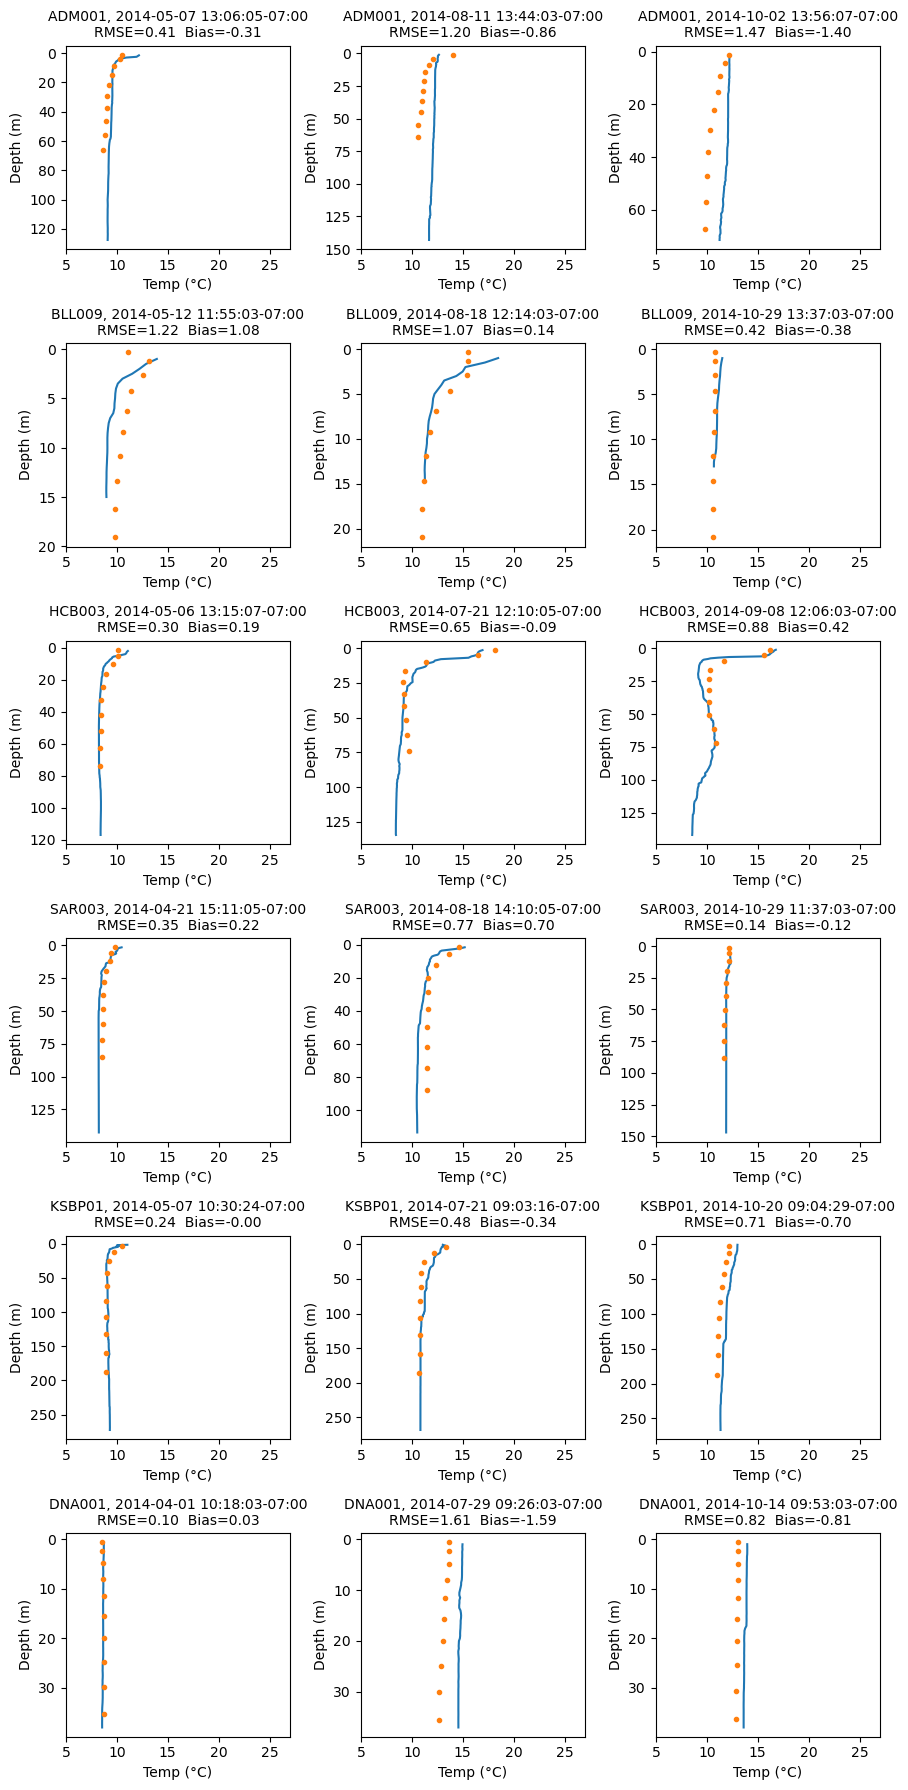

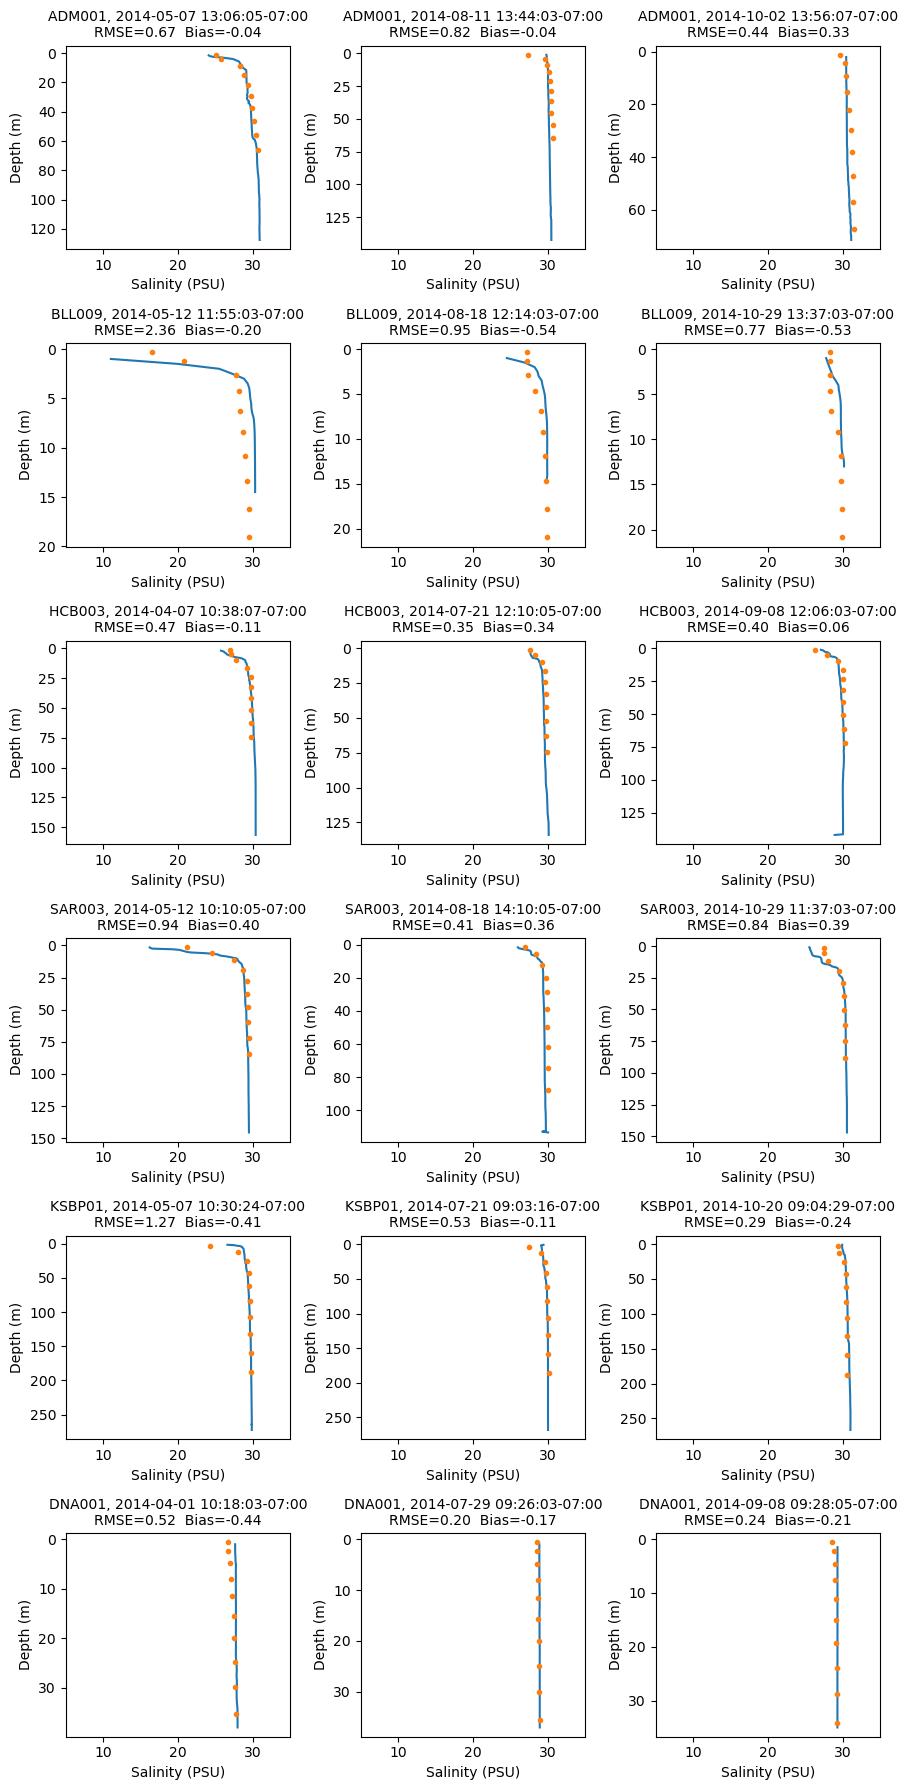

In [16]:
# Ranges of months to generate profile plots for
month_ranges = (
    (4, 5),
    (7, 8),
    (9, 10)
)
rand_seed = 4

for key,vals in datasets.items():
    fig, axs = plt.subplots(len(plot_stations), len(month_ranges),
                            figsize=(3*len(month_ranges), 3 * len(plot_stations)))
    d = vals['data']
    od = vals['obsdata']
    # Keep track of whether or not we found anything to plot among the ranges
    # given from this dataset
    plotted = False
    for i,mr in enumerate(month_ranges):
        for j,s in enumerate(plot_stations):
            ax = axs[j,i]
            # Pick a "random" cast from the time range, using a constant seed for reproducibility
            cast_candidates = od.loc[
                (od['datetime'].dt.month >= mr[0]) & (od['datetime'].dt.month <= mr[-1]) \
                & (od['location_id'] == s) & ~od['cast_id'].isna(), 'cast_id'
            ]
            if len(cast_candidates) == 0:
                continue
            obs_cast_id = cast_candidates.sample(1, random_state=rand_seed).iloc[0]

            obs = od.loc[od['cast_id'] == obs_cast_id].sort_values(by='depth')
            ax.plot(obs['value'], obs['depth'])
            cast_dt = obs['datetime'].iloc[0].tz_convert('US/Pacific')

            # Get model results that correspond to this cast_id. Use vals['data'] to fetch node and t,
            # retrieve all sigma layers, then recalculate matching depths using the same method as
            # process_cast
            node = obs['node'].iloc[0]
            cast_selector = d['cast_id'] == obs_cast_id
            t = d.loc[cast_selector, 't'].iloc[0]
            modeled_x = model_output[key][t,:,node-1]
            modeled_y = ((model_output['h'][node-1] + model_output['zeta'][t,node-1])
                         * model_output['siglay'][:] * -1)
            ax.plot(modeled_x, modeled_y, '.')
            
            fit, r, rmse, bias, n = vu.run_stats(d.loc[cast_selector, "observed"],
                                                 d.loc[cast_selector, "model"])

            ax.set_title(f'{s}, {cast_dt}\nRMSE={rmse:.2f}  Bias={bias:.2f}', fontsize=10)
            ax.set(ylabel='Depth (m)', xlabel=vals['ylabel'], xbound=vals['xbound'])
            ax.set_ylim(ax.get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
            plotted = True

    if plotted:
        fig.tight_layout()
        fig.savefig(out_file(f'{key}_validation_station_pr.png'))
    else:
        plt.close(fig)

Temperature skill by layer

In [17]:
temp_skill_by_layer = []
for s,group in temp_validation_df.groupby('sigma'):
    fit, rsq, rmse, bias, n = vu.run_stats(group["observed"], group["model"])
    temp_skill_by_layer.append((s,rsq,rmse,bias,n))
temp_skill_by_layer_df = pd.DataFrame(temp_skill_by_layer, columns=('sigma','R','RMSE','Bias','N')).set_index('sigma')
temp_skill_by_layer_df.to_csv(out_file('temp_skill_by_layer.csv'))
temp_skill_by_layer_df

,R,RMSE,Bias,N
sigma,,,,
1,0.922143,0.797610,0.461392,17444
2,0.865224,1.404718,-0.277973,6654
3,0.815568,1.281171,-0.026059,8374
4,0.824490,0.987224,-0.031718,8362
5,0.883736,0.804857,-0.081640,8350
6,0.925586,0.712645,-0.122200,8330
7,0.938812,0.670904,-0.127503,8280
8,0.941288,0.649896,-0.107223,6827
9,0.883507,0.654021,-0.054883,4409


Temperature skill over time

In [18]:
per_month = []
for name, group in temp_validation_df.groupby(temp_validation_df["datetime"].dt.date):
    fit, rsq, rmse, bias, n = vu.run_stats(group['observed'], group['model'])
    per_month.append([name, rsq, rmse, bias, n])

per_month_stats = pd.DataFrame(per_month, columns=["Date","R","RMSE","Bias","n"])
per_month_stats.to_csv(out_file('temp_skill_per_month.csv'))
per_month_stats

,Date,R,RMSE,Bias,n
0,2014-01-01,0.561523,0.442229,0.298849,73
1,2014-01-02,0.416120,0.588638,0.485042,114
2,2014-01-03,0.303556,0.880365,0.826316,114
3,2014-01-04,0.051778,0.958360,0.884757,114
4,2014-01-05,0.363038,0.772053,0.696733,114
...,...,...,...,...,...
358,2014-12-26,0.984683,0.480549,-0.459945,32
359,2014-12-27,0.986842,0.528470,-0.512508,32
360,2014-12-28,0.930894,0.659315,-0.624200,32
361,2014-12-29,0.636092,0.807887,-0.681215,24


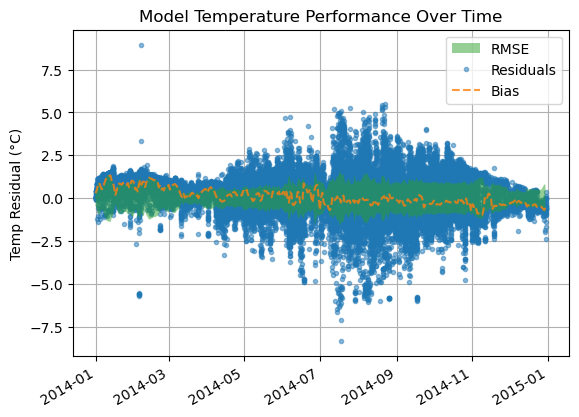

In [19]:
# Plot temperature residuals over time
temp_resids = temp_validation_df["model"] - temp_validation_df["observed"]
fig, ax = plt.subplots()
ax.fill_between(per_month_stats["Date"],
                per_month_stats["RMSE"],
                -per_month_stats["RMSE"],
                facecolor="tab:green", alpha=0.5, label="RMSE", zorder=4)
ax.plot(temp_validation_df["datetime"].to_numpy(), temp_resids, ".", label="Residuals", alpha=0.5)
ax.plot(per_month_stats["Date"].to_numpy(), per_month_stats["Bias"], "--", label="Bias", alpha=0.8, zorder=5)
ax.set(title="Model Temperature Performance Over Time", ylabel="Temp Residual (\u00b0C)")
ax.grid()
ax.legend()
fig.autofmt_xdate()
fig.savefig(out_file("temp_skill_vs_t.png"))